In [1]:
%pip install -q tensorflow scikit-learn pandas numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)


In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [4]:
df = pd.read_csv("data/sms_clean.csv")[["text","label"]]
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

X = df["text"].values
y = df["label"].values

splits = np.load("data/split_idx.npz")
train_idx, val_idx, test_idx = splits["train_idx"], splits["val_idx"], splits["test_idx"]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

len(X_train), len(X_val), len(X_test), y_train.mean(), y_val.mean(), y_test.mean()


(3619, 776, 776, 0.12627797734180712, 0.12628865979381443, 0.12628865979381443)

In [5]:
url_re = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
num_re = re.compile(r"\b\d+\b")

def normalize_text(s: str) -> str:
    s = s.lower()
    s = url_re.sub(" URL ", s)
    s = num_re.sub(" NUM ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

X_train_n = np.array([normalize_text(t) for t in X_train])
X_val_n   = np.array([normalize_text(t) for t in X_val])
X_test_n  = np.array([normalize_text(t) for t in X_test])


In [6]:
VOCAB_SIZE = 20000
SEQ_LEN = 60

vectorize = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN
)

vectorize.adapt(X_train_n)


In [7]:
BATCH = 64

def make_ds(texts, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(2048, seed=RANDOM_STATE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train_n, y_train, shuffle=True)
val_ds   = make_ds(X_val_n, y_val)
test_ds  = make_ds(X_test_n, y_test)


In [15]:
EMB_DIM = 128

inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorize(inputs)
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(x)

# CNN blocks
x = layers.Conv1D(128, 3, activation="relu", padding="same")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 60)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 60, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,617,601 (9.99 MB)

 Trainable params: 2,617,601 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# class weights: δίνει παραπάνω βάρος στο spam (1)
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
class_weight = {0: 1.0, 1: (neg / max(pos,1))}
class_weight


{0: 1.0, 1: 6.919037199124727}

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)


In [21]:
cb = EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=[cb],
    verbose=1
)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7721 - auc: 0.7783 - loss: 1.0466 - precision: 0.3095 - recall: 0.6566 - val_acc: 0.9330 - val_auc: 0.9796 - val_loss: 0.1535 - val_precision: 0.6769 - val_recall: 0.8980
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9367 - auc: 0.9648 - loss: 0.3698 - precision: 0.6815 - recall: 0.9014 - val_acc: 0.9820 - val_auc: 0.9922 - val_loss: 0.0800 - val_precision: 0.9118 - val_recall: 0.9490
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9824 - auc: 0.9967 - loss: 0.1205 - precision: 0.8980 - recall: 0.9723 - val_acc: 0.9781 - val_auc: 0.9941 - val_loss: 0.0731 - val_precision: 0.8785 - val_recall: 0.9592
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9930 - auc: 0.9999 - loss: 0.0372 - precision: 0.9532 - recall: 0.9969 - val_acc: 0.9897 - val_auc: 0.9897 - val_loss: 0.0454 - val_precision: 0.9592 - val_recall: 0.9592
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9985 - auc: 1.00

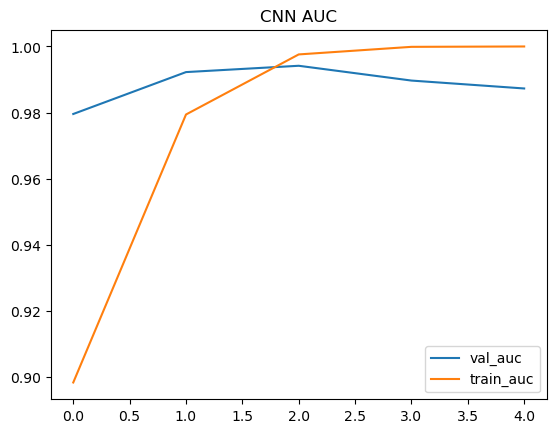

In [22]:
plt.figure()
plt.plot(history.history["val_auc"], label="val_auc")
plt.plot(history.history["auc"], label="train_auc")
plt.legend()
plt.title("CNN AUC")
plt.savefig("results/cnn_learning_auc.png", dpi=200, bbox_inches="tight")
plt.show()


In [23]:
proba = model.predict(test_ds).ravel()
pred = (proba >= 0.5).astype(int)




13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test_metrics = {
    "accuracy": float(accuracy_score(y_test, pred)),
    "precision_spam": float(precision_score(y_test, pred, pos_label=1, zero_division=0)),
    "recall_spam": float(recall_score(y_test, pred, pos_label=1, zero_division=0)),
    "f1_spam": float(f1_score(y_test, pred, pos_label=1, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, proba)),
}
test_metrics


{'accuracy': 0.9729381443298969,
 'precision_spam': 0.8468468468468469,
 'recall_spam': 0.9591836734693877,
 'f1_spam': 0.8995215311004785,
 'roc_auc': 0.9919932574799832}

In [29]:
pd.DataFrame([test_metrics]).to_csv("results/cnn_metrics_test.csv", index=False)
print("Saved -> results/cnn_metrics_test.csv")


Saved -> results/cnn_metrics_test.csv


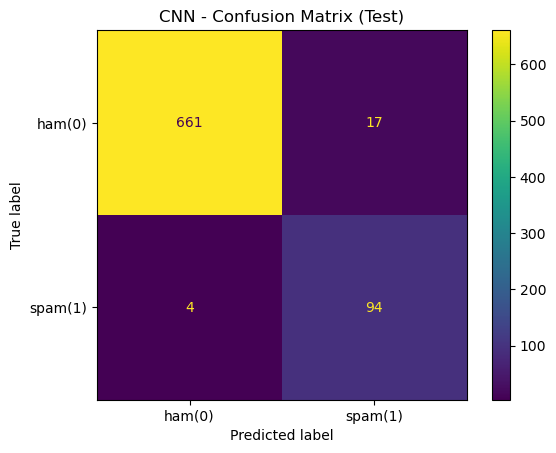

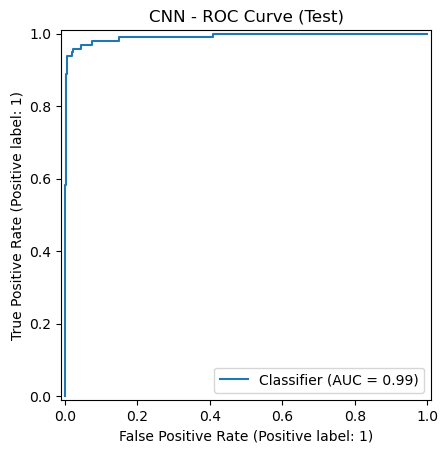

In [31]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham(0)", "spam(1)"])
disp.plot(values_format="d")
plt.title("CNN - Confusion Matrix (Test)")
plt.savefig("results/cnn_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("CNN - ROC Curve (Test)")
plt.savefig("results/cnn_roc_curve.png", dpi=200, bbox_inches="tight")
plt.show()


In [33]:

import pandas as pd
from pathlib import Path
import numpy as np

Path("results").mkdir(exist_ok=True)

# 1) save model (important for LIME later without retraining)
model.save("results/cnn_model.keras")
print("Saved -> results/cnn_model.keras")

# 2) Ensure we also have the raw texts for the test set.
# If you already have X_test as an array of strings, use that.
# Otherwise, load from the saved dataset + split file:
df = pd.read_csv("data/sms_clean.csv")[["text","label"]]
splits = np.load("data/split_idx.npz")
test_idx = splits["test_idx"]
X_test_text = df.iloc[test_idx]["text"].astype(str).values

y_true = y_test.astype(int)
spam_prob = proba.reshape(-1)
y_pred = pred.astype(int)

pd.DataFrame({
    "text": X_test_text,
    "y_true": y_true,
    "spam_prob": spam_prob,
    "y_pred": y_pred
}).to_csv("results/cnn_test_scores.csv", index=False)

pd.DataFrame({"text": X_test_text[(y_true==0) & (y_pred==1)]}).to_csv("results/cnn_false_positives.csv", index=False)
pd.DataFrame({"text": X_test_text[(y_true==1) & (y_pred==0)]}).to_csv("results/cnn_false_negatives.csv", index=False)

print("Saved -> results/cnn_test_scores.csv")
print("Saved -> results/cnn_false_positives.csv")
print("Saved -> results/cnn_false_negatives.csv")

Saved -> results/cnn_model.keras
Saved -> results/cnn_test_scores.csv
Saved -> results/cnn_false_positives.csv
Saved -> results/cnn_false_negatives.csv
